# **Installing dependencies**

In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision]
# !pip install -I huggingface_hub
# !pip install --ignore-installed huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.6/478.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip /content/cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [ ]:
from collections import OrderedDict
from typing import List, Tuple


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cpu using PyTorch 2.5.0+cu121 and Flower 1.12.0


# **Dataset**

In [ ]:
# prompt: there is two classes Parasitized and  Uninfected, read all images where the paths are as follows /content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png, and read only the images not anything else

import cv2
import os
from PIL import Image

Parasitized_path = '/content/cell_images/Parasitized/'
Uninfected_path = '/content/cell_images/Uninfected/'

Parasitized_images = []
Uninfected_images = []

for img in os.listdir(Parasitized_path):
    # image = cv2.imread(Parasitized_path + img)
    if(img.lower().endswith(".png")):
      image = np.array(Image.open(Parasitized_path + img).resize((70,70)))
      if image is not None: # Check if the image was loaded successfully
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Parasitized_images.append(image)


for img in os.listdir(Uninfected_path):
    # image = cv2.imread(Uninfected_path + img)
    if(img.lower().endswith(".png")):
      # image = np.array(Image.open(Uninfected_path + img).convert('L').resize((70,70)))
      image = np.array(Image.open(Uninfected_path + img).resize((70,70)))
      if image is not None: # Check if the image was loaded successfully
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Uninfected_images.append(image)

# Now you have two lists: Parasitized_images and Uninfected_images, containing the loaded images
print(f"Number of Parasitized images: {len(Parasitized_images)}")
print(f"Number of Uninfected images: {len(Uninfected_images)}")

# resized_parasitized_images = [cv2.resize(img, (70, 70)) for img in Parasitized_images]
# resized_uninfected_images = [cv2.resize(img, (70, 70)) for img in Uninfected_images]

# # Now you have two lists with resized images
# print(f"Number of resized Parasitized images: {len(resized_parasitized_images)}")
# print(f"Number of resized Uninfected images: {len(resized_uninfected_images)}")


# images = resized_parasitized_images + resized_uninfected_images
# labels = ['Parasitized'] * len(resized_parasitized_images) + ['Uninfected'] * len(resized_uninfected_images)


# images = Parasitized_images + Uninfected_images
# labels = ['Parasitized'] * len(Parasitized_images) + ['Uninfected'] * len(Uninfected_images)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Parasitized images: 13779
Number of Uninfected images: 13779


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'images' and 'labels' are defined as in the previous code
images = Parasitized_images + Uninfected_images
labels = ['Parasitized'] * len(Parasitized_images) + ['Uninfected'] * len(Uninfected_images)

# Convert labels to numerical representation
label_mapping = {'Parasitized': 1, 'Uninfected': 0}
numerical_labels = [label_mapping[label] for label in labels]

# Convert images to a NumPy array (if not already)
images = np.array(images)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, numerical_labels, test_size=0.2, random_state=42
)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", len(y_train))
print("X_test shape:", X_test.shape)
print("y_test shape:", len(y_test))

X_train shape: (22046, 70, 70, 3)
y_train shape: 22046
X_test shape: (5512, 70, 70, 3)
y_test shape: 5512


In [ ]:
# prompt: from the training dataset pick only 500/500 false/true samples and assign them in a new train variable

# Find indices of true and false labels in y_train
true_indices = np.where(y_train == 1)[0]
false_indices = np.where(y_train == 0)[0]

# Randomly select 500 samples from each class
num_samples = 2500
selected_true_indices = np.random.choice(true_indices, size=min(num_samples, len(true_indices)), replace=False)
selected_false_indices = np.random.choice(false_indices, size=min(num_samples, len(false_indices)), replace=False)

# Combine selected indices
selected_indices = np.concatenate((selected_true_indices, selected_false_indices))

# Create new training data
X_train = X_train[selected_indices]
y_train = y_train[selected_indices]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X_train shape: (5000, 70, 70, 3)
y_train shape: (5000,)


In [ ]:
# prompt: from the testing dataset pick only 500/500 false/true samples and assign them in a new test variable

# Find indices of true and false labels in y_train
true_indices = np.where(y_test == 1)[0]
false_indices = np.where(y_test == 0)[0]

# Randomly select 500 samples from each class
num_samples = 10
selected_true_indices = np.random.choice(true_indices, size=min(num_samples, len(true_indices)), replace=False)
selected_false_indices = np.random.choice(false_indices, size=min(num_samples, len(false_indices)), replace=False)

# Combine selected indices
selected_indices = np.concatenate((selected_true_indices, selected_false_indices))

# Create new testing data
X_test_sample = X_test[selected_indices]
y_test_sample = y_test[selected_indices]

print("X_test shape:", X_test_sample.shape)
print("y_test shape:", y_test_sample.shape)

X_test shape: (20, 70, 70, 3)
y_test shape: (20,)


In [ ]:
#@title Dirichlet Partitioner
from flwr_datasets.partitioner import DirichletPartitioner
from datasets import Dataset, DatasetDict,concatenate_datasets

NUM_CLIENTS = 8
BATCH_SIZE = 32
NUM_CLASSES = 2

def load_datasets():
    # fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    data = {"features": X_train, "labels": y_train}
    dataset_train = Dataset.from_dict(data)

    partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, partition_by="labels",
                                       alpha=0.3, min_partition_size=3,
                                      self_balancing=True)
    partitioner.dataset = dataset_train

    # data = {"features": X_test, "labels": y_test}
    data = {"features": X_test_sample, "labels": y_test_sample}
    dataset_test = Dataset.from_dict(data)

    data = {"features": X_test, "labels": y_test}
    dataset_test_full = Dataset.from_dict(data)

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same

        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize(
                    size=(70, 70)
                ),

                transforms.Normalize((0.5), (0.5)),
            ]
        )
        batch["features"] = [transform(np.array(img,dtype=np.float32)) for img in batch["features"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        # partition = partitioner.load_partition(partition_id, "train")
        partition = partitioner.load_partition(partition_id)
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))

        # trainloaders.append(DataLoader(partition, batch_size=BATCH_SIZE))

    # testset = partitioner.load_split("test").with_transform(apply_transforms)
    # testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    dataset_test = dataset_test.with_transform(apply_transforms)
    testloader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

    dataset_test_full = dataset_test_full.with_transform(apply_transforms)
    testloader_full = DataLoader(dataset_test_full, batch_size=BATCH_SIZE)

    return trainloaders, testloader_full, valloaders, testloader


trainloaders, testloader_full, valloaders, testloader = load_datasets()

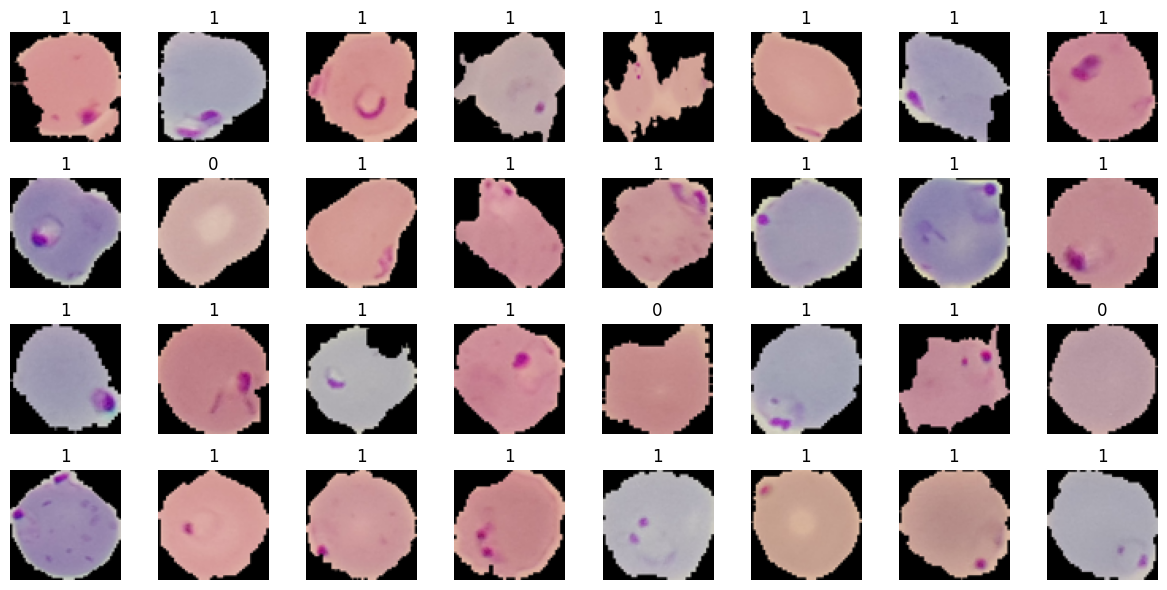

In [ ]:
batch = next(iter(trainloaders[0]))
images, labels = batch["features"], batch["labels"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(str(int(labels[i].item())))
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

# **Model and Training**

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (3,3))
        self.pool = nn.MaxPool2d((2,2), stride=2)
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6, 16, (6,6))
        self.batchnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, (12,12))
        self.batchnorm3 = nn.BatchNorm2d(32)


        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(32, num_classes)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 11)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.batchnorm1(self.dropout(self.pool(F.relu(self.conv1(x)))))
        x = self.batchnorm2(self.dropout(self.pool(F.relu(self.conv2(x)))))
        x = self.batchnorm3(self.dropout(self.pool(F.relu(self.conv3(x)))))

        # x = x.view(-1, 16 * 5 * 5)
        x = torch.flatten(x, start_dim=1)
        # x = F.softsign(self.fc1(x))
        # x = F.softsign(self.fc2(x))
        x = self.fc1(x)
        return x.squeeze(1)

In [ ]:
#@title Multi
def train(net, trainloader, epochs: int, verbose=True):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    # optimizer = torch.optim.SGD(net.parameters(),lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            loss, accuracy = test(net, testloader)
            print(f"Epoch : {epoch+1} | Train loss : {epoch_loss:.4f} | Train Acc : {epoch_acc:.4f} | Test loss : {loss:.4f} | Test Acc : {accuracy:.4f}")
            # print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels.long()).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy



def get_logits(net, trainloader):
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()
    logits = torch.tensor([])#.to(DEVICE)
    with torch.no_grad():
        for batch in trainloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            outputs = net(images)
            logits = torch.cat([logits,outputs],dim=0)
    return logits

In [ ]:
#@title binary
def train(net, trainloader, epochs: int, verbose=True):
    """Train the network on the training set."""
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCELoss()
    # optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    optimizer = torch.optim.SGD(net.parameters(),lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.round(outputs.data) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            loss, accuracy = test(net, testloader)
            print(f"Epoch : {epoch+1} | Train loss : {epoch_loss:.4f} | Train Acc : {epoch_acc:.4f} | Test loss : {loss:.4f} | Test Acc : {accuracy:.4f}")
            # print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels.float()).item()
            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# **Federated Learning**

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
        # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
        return [val.cpu().numpy() for name, val in net.state_dict().items() if 'bn' not in name]

def set_parameters(net, parameters: List[np.ndarray]) -> None:
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in net.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=False)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=3)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]


    # Create a  single Flower client representing a single organization
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config,
):
    net = Net().to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"###### TEST ###### Server-side evaluation :  loss {loss} | accuracy {accuracy}")
    return loss, {"accuracy TEST": accuracy}

In [ ]:
global_net = Net().to(DEVICE)
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            global_net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(global_net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [ ]:
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.8,  # Sample 100% of available clients for training
#     fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
#     min_fit_clients=10,  # Never sample less than 10 clients for training
#     min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
#     min_available_clients=10,  # Wait until all 10 clients are available
#     evaluate_metrics_aggregation_fn=weighted_average, # To print the Accuracy after training
#     evaluate_fn=evaluate, # The `evaluate` function will be by Flower called after every round
# )
strategy = SaveModelStrategy(
    fraction_fit=0.8,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=1,  # Never sample less than 10 clients for training
    min_evaluate_clients=1,  # Never sample less than 5 clients for evaluation
    min_available_clients=1,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # To print the Accuracy after training
    evaluate_fn=evaluate, # The `evaluate` function will be by Flower called after every round
)
# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-10-23 17:26:43,834	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4004691148.0, 'memory': 8009382299.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=17294) 2024-10-23 17:26:50.527726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=17294) 2024-10-23 17:26:50.574179: E external/local_xla/xla/str

(ClientAppActor pid=17295) [Client 1] get_parameters


INFO :      initial parameters (loss, other metrics): 0.03496040105819702, {'accuracy TEST': 0.5}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 8)


###### TEST ###### Server-side evaluation :  loss 0.03496040105819702 | accuracy 0.5


(ClientAppActor pid=17295) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17295) 
(ClientAppActor pid=17295)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17295)             entirely in future versions of Flower.
(ClientAppActor pid=17295)         


(ClientAppActor pid=17295) [Client 2] fit, config: {}
(ClientAppActor pid=17295) Epoch : 1 | Train loss : 0.0239 | Train Acc : 0.5738 | Test loss : 0.0342 | Test Acc : 0.6500
(ClientAppActor pid=17295) Epoch : 2 | Train loss : 0.0132 | Train Acc : 0.8962 | Test loss : 0.0630 | Test Acc : 0.5000


(raylet) [2024-10-23 17:40:58,533 E 17150 17150] (raylet) node_manager.cc:2967: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 43d789aea9f1458fe67ebf8ac6142a4f988a56b54dbeabfe6d7f7314, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-10-23 17:41:02,458 E 17150 17150] (raylet) local_object_manager.cc:360: Failed to send object spilling r

###### TEST ###### Server-side evaluation :  loss 0.03496040105819702 | accuracy 0.5


(raylet) [2024-10-23 18:10:20,968 E 17150 17150] (raylet) local_object_manager.cc:360: Failed to send object spilling request: GrpcUnavailable: RPC Error message: Socket closed; RPC Error details: 
(raylet) [2024-10-23 18:10:47,936 E 17150 17150] (raylet) node_manager.cc:2967: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 43d789aea9f1458fe67ebf8ac6142a4f988a56b54dbeabfe6d7f7314, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker 

###### TEST ###### Server-side evaluation :  loss 0.03496040105819702 | accuracy 0.5


(raylet) [2024-10-23 19:08:02,684 E 17150 17150] (raylet) local_object_manager.cc:360: Failed to send object spilling request: GrpcUnavailable: RPC Error message: Socket closed; RPC Error details: 
(raylet) [2024-10-23 19:08:17,555 E 17150 17150] (raylet) node_manager.cc:2967: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 43d789aea9f1458fe67ebf8ac6142a4f988a56b54dbeabfe6d7f7314, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker 

KeyboardInterrupt: 

In [ ]:
# @title loading saved parameters
# import glob
# list_of_files = [fname for fname in glob.glob("./model_round_*")]
# latest_round_file = max(list_of_files, key=os.path.getctime)
# print("Loading pre-trained model from: ", latest_round_file)
# state_dict = torch.load(latest_round_file)
# global_net.load_state_dict(state_dict)
# state_dict_ndarrays = [v.cpu().numpy() for v in global_net.state_dict().values()]
# parameters = fl.common.ndarrays_to_parameters(state_dict_ndarrays) # You can use  this parameters in initializing the strategy

#@title loading saved parameters
import glob
model = Net(num_classes=NUM_CLASSES).to(DEVICE)
list_of_files = [fname for fname in glob.glob(f"./model_round_*")]
latest_round_file = max(list_of_files, key=os.path.getctime)
print("Loading pre-trained model from: ", latest_round_file)
# lastes_round_file = f"/model_round_100_{EXP}.pth"
state_dict = torch.load(latest_round_file)
model.load_state_dict(state_dict)
state_dict_ndarrays = [v.cpu().numpy() for v in model.state_dict().values()]
parameters = fl.common.ndarrays_to_parameters(state_dict_ndarrays) # You can use  this parameters in initializing the strategy

In [ ]:
loss, accuracy = test(model, testloader_full)
print(f"###### TEST EVALUATION ###### Loss: {loss} | Accuracy: {accuracy}")


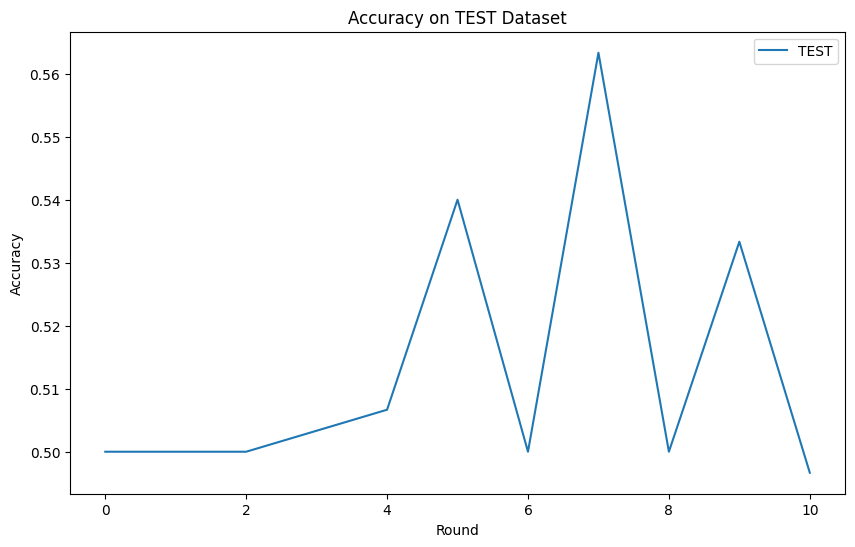

In [ ]:
import matplotlib.pyplot as plt

# Extract the accuracy metric from the history object
accuracy_test = [x[1] for x in history.metrics_centralized['accuracy TEST']]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the accuracy values
plt.plot(accuracy_test,label="TEST")

# Set the title and axis labels
plt.title("Accuracy on TEST Dataset")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
# Display the plot
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Extract the accuracy metric from the history object
# loss_test = [x[1] for x in history.metrics_centralized['loss']]

# # Create a plot
# plt.figure(figsize=(10, 6))

# # Plot the loss values
# plt.plot(loss_test,label="TEST")

# # Set the title and axis labels
# plt.title("LOSS on TEST Dataset")
# plt.xlabel("Round")
# plt.ylabel("Accuracy")
# plt.legend()
# # Display the plot
# plt.show()


Exception ignored in: <function _xla_gc_callback at 0x7ad189d01120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


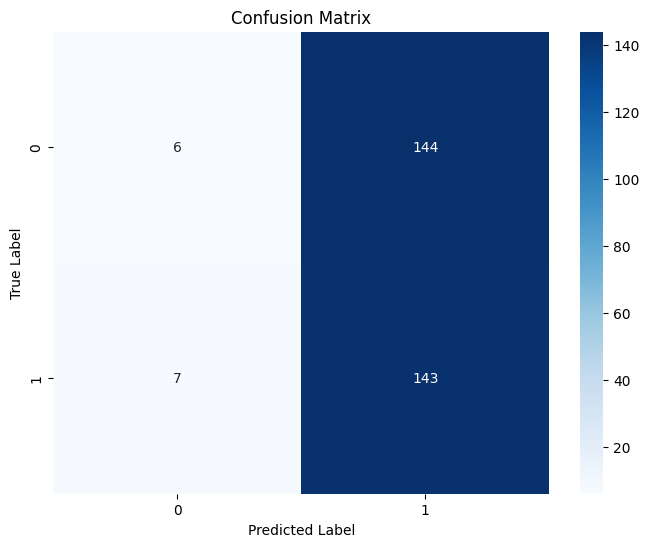

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Get the model's predictions on the public dataset

predictions = get_logits(model, testloader)

# Convert the predictions to class labels
predictions = torch.argmax(predictions, dim=1)

# Get the true labels for the public dataset
true_labels = torch.cat([batch["labels"] for batch in testloader])

# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions.cpu())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

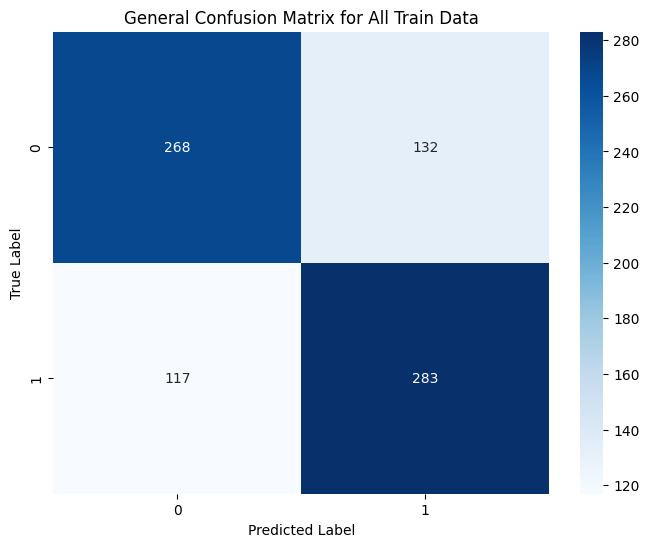

In [ ]:


# Initialize variables
all_predictions = []
all_true_labels = []

# Loop through each trainloader
for trainloader in trainloaders:
  # Get the model's predictions on the trainloader
  predictions = get_logits(model, trainloader)

  # Convert the predictions to class labels
  predictions = torch.argmax(predictions, dim=1).cpu()

  # Get the true labels for the trainloader
  true_labels = torch.cat([batch["labels"] for batch in trainloader])

  # Add the predictions and true labels to the lists
  all_predictions.extend(predictions.tolist())
  all_true_labels.extend(true_labels.tolist())

# Create the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('General Confusion Matrix for All Train Data')
plt.show()


In [ ]:

accuracies = []
for trainloader in trainloaders:
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in trainloader:
      inputs, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  accuracies.append(accuracy)

mid = 0
# Print the accuracy for each trainloader
for i, accuracy in enumerate(accuracies):
  print(f"Accuracy for trainloader {i+1}: {accuracy:.2f}%")
  mid += accuracy
mid = mid / len(accuracies)
print(f"Average Accuracy: {mid:.2f}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for trainloader 1: 68.88%
Average Accuracy: 68.88%
